In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import functions as fun
plt.rcParams['figure.figsize'] = [20, 10]

store_df = pd.read_csv('data/store.csv')
train_df = pd.read_csv('data/train.csv')

def merge_files(left_df, right_df):
    df = left_df.merge(right_df, on='Store', how='left')
    return df

In [3]:
print(store_df.isnull().sum())
print(train_df.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
Date                 0
Store            19301
DayOfWeek        19017
Sales            19027
Customers        19091
Open             19186
Promo            19194
StateHoliday     19254
SchoolHoliday    19337
dtype: int64


In [4]:
#
# CLEANING STORE DATA
#

# Promo2SinceWeek, Promo2SinceYear, PromoInterval are only NaN when Promo2 is 0, so it's not a problem:
print(store_df.loc[(store_df['Promo2'] == 0) & 
                   ~pd.isna(store_df['Promo2SinceWeek']) & 
                   ~pd.isna(store_df['Promo2SinceYear']) & 
                   ~pd.isna(store_df['PromoInterval'])].empty)

# We fill the competition dates with our firs day of data:
store_df_clean = store_df.fillna({'CompetitionOpenSinceYear':2013.0})
store_df_clean = store_df_clean.fillna({'CompetitionOpenSinceMonth':1.0})

#store_df_clean.head(50)

True


In [5]:
# There are 3 NaN spaces with in 'CompetitionDistance':
store_df_clean.loc[pd.isna(store_df_clean['CompetitionDistance'])].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,1.0,2013.0,0,NaN,NaN,NaN
621,622,a,c,NaN,1.0,2013.0,0,NaN,NaN,NaN
878,879,d,a,NaN,1.0,2013.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


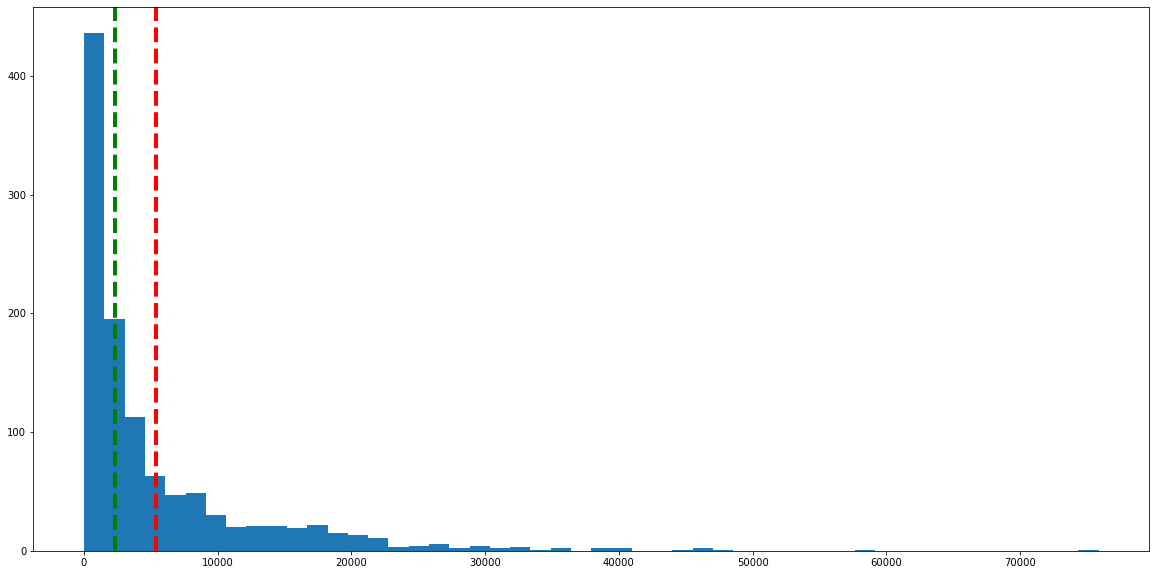

In [6]:
# Plotting distribution, mean and median to see which value we could use to fill the gaps: 
mean = store_df_clean["CompetitionDistance"].mean(axis=0)
median = store_df_clean["CompetitionDistance"].median(axis=0)
plt.hist(store_df_clean["CompetitionDistance"], bins=50)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=4)
plt.axvline(median, color='g', linestyle='dashed', linewidth=4)

# Seems like median is a reasonable value to fill those NaN spaces:
store_df_clean = store_df_clean.fillna({'CompetitionDistance':median})

In [7]:
#
# MERGE TRAIN AND STORE DATA AND CLEAN
#
df = train_df.merge(store_df_clean, on='Store', how='left')
#df.loc[df['Date'] == '2013-01-21'].head(50)

In [8]:
print(df.isnull().sum())

Date                              0
Store                         19301
DayOfWeek                     19017
Sales                         19027
Customers                     19091
Open                          19186
Promo                         19194
StateHoliday                  19254
SchoolHoliday                 19337
StoreType                     19301
Assortment                    19301
CompetitionDistance           19301
CompetitionOpenSinceMonth     19301
CompetitionOpenSinceYear      19301
Promo2                        19301
Promo2SinceWeek              322946
Promo2SinceYear              322946
PromoInterval                322946
dtype: int64


In [9]:
# Convert Date column to DateTime
df2 = df
df2['Date'] = pd.to_datetime(df2['Date'])
#df2.head(50)

In [10]:
# Set NaN values on 'DayOfWeek', 'StateHoliday' and 'SchoolHoliday' to the mode of the same day (most common value of all stores)

ids = pd.isnull(df2['DayOfWeek'])
df3 = df2
for i in range(df3.shape[0]):
    if pd.isna(df3['DayOfWeek'].iloc[i]):
        date = df3['Date'].iloc[i]
        mode = df3['DayOfWeek'].loc[df3['Date'] == date].mode()
        df3['DayOfWeek'].iloc[i] = mode[0]
    if pd.isna(df3['StateHoliday'].iloc[i]):
        date = df3['Date'].iloc[i]
        mode = df3['StateHoliday'].loc[df3['Date'] == date].mode()
        df3['StateHoliday'].iloc[i] = mode[0]
    if pd.isna(df3['SchoolHoliday'].iloc[i]):
        date = df3['Date'].iloc[i]
        mode = df3['SchoolHoliday'].loc[df3['Date'] == date].mode()
        df3['SchoolHoliday'].iloc[i] = mode[0]
    
#df3.head(50)

/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# Save
df3.to_pickle('data/clean_data.pkl')

In [12]:
# Load to check that it's fine and print data for a single store
df4 = pd.read_pickle('data/clean_data_post_comp.pkl')
#df4.loc[df['Store'] == 330].head(50)

In [13]:
# Fill NaN 'Promo' as 0:
df5 = df4.fillna({'Promo':0})

In [15]:
# Remove all rows with Sales = 0 (don't matter for the model):
df6 = df5[df5['Sales'] != 0]

# That should also include rows where Sales = NaN, but Open = 0:
#df6 = df6.drop(df6['Open'].loc[df6['Open']==0].index)

#df6.head(50)

In [ ]:
# As we are not using zero-sale days, 'Open' cells will always be 1, 
# therefore it doesn't offer any information to our model, so we delete this column entirely:
df7 = df6.drop(columns='Open')

In [ ]:
df7.to_pickle('data/clean_data_post_comp.pkl')

In [ ]:
# TODO: clean NaN from 'Stores' first, then delete the dropna part from cell below

In [ ]:
empty_sales_df = df7.loc[pd.isna(df7['Sales']) & df7['StateHoliday'] == 0].dropna(subset = ["Store"])
empty_sales_df.head(50)

In [ ]:
# Fill all NaN Sales with the average of the past 4 weeks on that same week day
# Only for days where StateHoliday = 0

empty_sales_df = df7.loc[pd.isna(df7['Sales']) & df7['StateHoliday'] == 0].dropna(subset = ["Store"])

df8 = df7

for i in range(100):#empty_sales_df.shape[0]):
    target_date = empty_sales_df.iloc[i, 0]
    target_store = empty_sales_df.iloc[i, 1]
    target_weekday = empty_sales_df.iloc[i, 2]
    target_store_df = df8.loc[df8['Store'] == target_store]
    df_filtered_weekday = target_store_df.loc[target_store_df['DayOfWeek'] == target_weekday]
    df_filtered_weekday2 = df_filtered_weekday.reset_index()
    
    # If January 2013 (first month in dataset), then take average of January:
    if(empty_sales_df.iloc[i, 0].month == 1 and empty_sales_df.iloc[i, 0].year == 2013):
        mean = df_filtered_weekday2.iloc[0:3].dropna(subset = ["Sales"])['Sales'].mean()
        print(df_filtered_weekday2.iloc[0:3].dropna(subset = ["Sales"])['Sales'])
        
    # If not, take the mean of last 4 weeks:
    else:
        idx_target = df_filtered_weekday2.loc[df_filtered_weekday2.Date == target_date].index.tolist()[0]
        mean = df_filtered_weekday2.iloc[idx_target-4:idx_target].dropna(subset = ["Sales"])['Sales'].mean()
    df8['Sales'].loc[(df8['Store']==target_store) & (df8['Date']==target_date)] = mean
    #empty_sales_df['Sales'].loc[(empty_sales_df['Store']==target_store) & (empty_sales_df['Date']==target_date)] = mean

In [ ]:
# TODO: Fill NaN in 'Customers'
#       Suggestion: use some kind of average Sales per Customers metric

In [ ]:
empty_sales_df.head(50)
#df8.loc[pd.isna(df7['Sales'])].head(50)

In [ ]:
df_filtered_weekday2.iloc[idx_target-4:idx_target]

In [ ]:
target_store_df = df7.loc[df7['Store'] == target_store]
df_filtered_weekday = target_store_df.loc[target_store_df['DayOfWeek']==target_row.iloc[0, 2]]
df_filtered_weekday2 = df_filtered_weekday.reset_index()
idx_target = df_filtered_weekday2.loc[df_filtered_weekday2.Date == target_row.iloc[0, 0]].index.tolist()[0]
mean = df_filtered_weekday2.iloc[idx_target-4:idx_target]['Sales'].mean()
df_filtered_weekday2.head(50)
#df_filtered_weekday.iloc[idx_target]

In [ ]:
df7['Sales'].loc[(df7['Store']==target_store) & (df7['Date']==target_date)]

In [ ]:
df8.isnull().sum()

In [ ]:
df8.to_pickle('data/clean_data_post_comp.pkl')